In [4]:
%load_ext autoreload
%autoreload 2

import hyp
import utils
import os
import json
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from visualization import plot_circadian_cycle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
settings = json.load(open('./settings.json'))

path = settings['general']['dataset_dir']

sub = settings['general']['sub']
sub = utils.check_all_setting(sub, 'sub', path, prefix='sub')

hours_counts = []
counts = []

for _sub in tqdm(sub, desc='Subjects', unit='sub'):
    path = os.path.join(settings['general']['dataset_dir'], settings['general']['eeg_subdir'].split('ses')[0].replace(
            '<SUB>', _sub))

    ses = settings['general']['ses']
    ses = utils.check_all_setting(ses, 'ses', path, suffix='w')

    for _ses in ses:
        path = os.path.join(settings['general']['dataset_dir'], settings['general']['eeg_subdir'].replace(
            '<SUB>', _sub).replace('<SES>', _ses))
        
        run = settings['general']['run']
        run = utils.check_all_setting(run, 'run', path, suffix=settings['hyp']['suffix'])

        output_dir = utils.create_output_dir(settings['general']['output_dir'], _sub, _ses)

        dfs = []

        for _run in run:
            filename = utils.get_filename(settings, _sub, _ses, _run, settings['hyp']['suffix'])
            filename = os.path.join(path, filename)

            dfs.append(hyp.get_stages(filename, settings))

        if len(dfs) != 0:
            df = pd.concat(dfs, ignore_index=True)

            hours_counts.append(hyp.count_full_hours(df, settings, tolerance=45))
            quiet_counts = hyp.get_stage_cycle(df, settings, description='QuietSleep', tolerance=45)
            active_counts = hyp.get_stage_cycle(df, settings, description='ActiveSleep', tolerance=45)
            soas_counts = hyp.get_stage_cycle(df, settings, description='SleepOnsetActiveSleep', tolerance=45)
            wake_counts = hyp.get_stage_cycle(df, settings, description='Wake', tolerance=45)
            counts.append([quiet_counts, active_counts, soas_counts, wake_counts])
            # hyp.count_adjacent_stages_per_hour(df, settings, description='ActiveSleep', min_duration=60)

hours_counts = np.sum(hours_counts, axis=0)

counts = np.sum(counts, axis=0)
counts = np.divide(counts, hours_counts, out=np.zeros_like(counts), where=hours_counts!=0)

Subjects:   0%|          | 0/37 [00:00<?, ?sub/s]

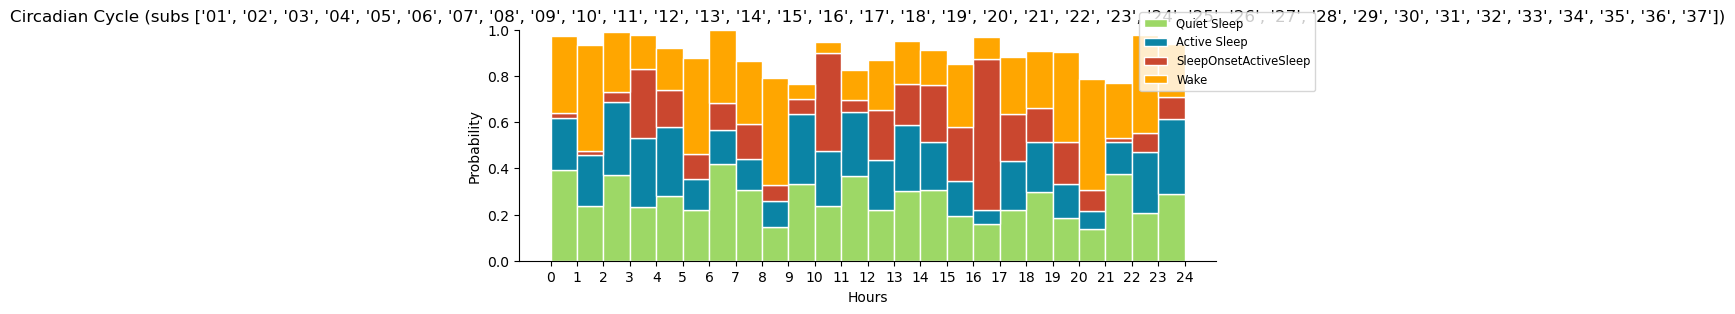

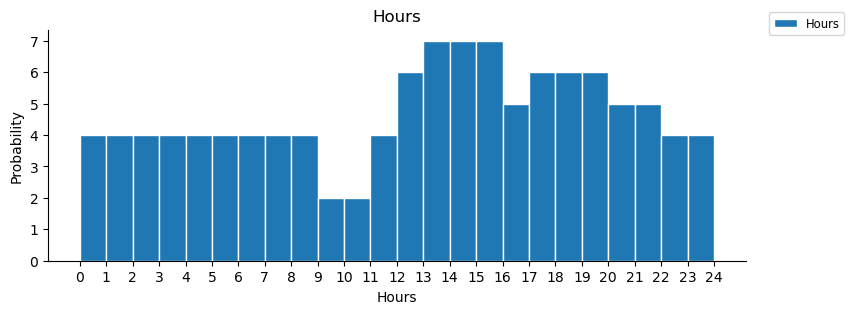

In [6]:
plot_circadian_cycle(counts, labels=('Quiet Sleep', 'Active Sleep', 'SleepOnsetActiveSleep', 'Wake'), color=['#9DD866', '#0B84A5','#CA472F', '#FFA600'], title='Circadian Cycle (subs ' + str(sub) + ')')
plot_circadian_cycle([hours_counts], labels=['Hours'], title='Hours', ylim=None)